Finite Element (FE) variables
======

Underworld solves finite element variables, such as temperature and pressure fields, on a spatial grid called a mesh. The data for these fields is stored in finite element variables which are solved on the mesh using underworld. How to use the meshes was the topic of the previous user guide, here we continue on from there by looking at the finite element variables themselves.



**This notebook is broken down into the following examples:**
1. setting up FE variables on a mesh
2. setting initial conditons on FE variables
3. loading and saving FE variable data

**Keywords:** FE variables, finite elements, load/save, initial conditions

Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

Setting FE variable on a mesh
-----

Set simulation parameters. Number of spatial dimensions and the resolution.

In [2]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 4

Create basic mesh objects. For more information on these see **02_Meshing.ipynb**.

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight) )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

**Create a copy of the desired mesh for each FE variable.**

For example the temperature uses the mesh for the cell edges, the ``elementMesh``, so we create a new mesh object called the ``temperatureMesh`` which is a copy of this edge mesh. This convention means that we can easily distinguish which mesh we are using for each FE variable. This is particularly useful when dealing with temperature and pressure fields as the pressure is solved on a different mesh (the subMesh).

In [4]:
temperatureMesh = elementMesh

**Create an FE variable**

Create a Finite Element (FE) variable for the temperature field using the ``temperatureMesh``. Note that since the temperature has a single value at each point in space then it has a single degree of freedom, so the last parameter in the command below is set to one.

In [5]:
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Set initial conditions on the FE variable
-----

The temperature field has now been created and associated with a particular mesh. Now we can assign values at each grid point. To set or change the data for an FE variable the following command is used

    temperatureField.data[index] = value

where ``value`` can be a number or (more likely) a function and ``index`` refers to the mesh node point number.

**Example 1: Index**

To give an idea of what the mesh index means, we will plot the index as a colour in space.

In [6]:
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = index

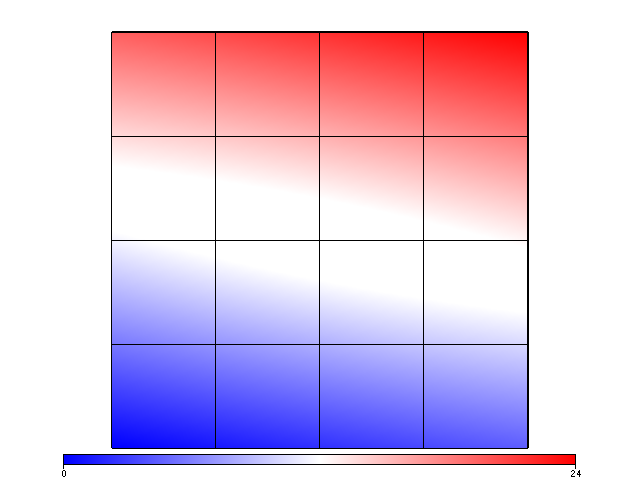

In [7]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.Mesh(temperatureMesh, colourBar = False)
fig.show()

The mesh point index increases from zero at the bottom left, to the right first and then the next line. We can also see this if we print out the values of the first ``res`` mesh points.

In [8]:
print('Resolution = {0:3d}'.format(res))
# the enumerate function outputs the mesh index and spatial coordinate data for each mesh node point
for index, coord in enumerate(temperatureMesh.data):
    if(index<2*(res+1)):
        print('T = {0:1.0f}; x = {1:.3f}, z = {2:.3f}'.format(temperatureField.data[index][0], coord[0], coord[1]))

Resolution =   4
T = 0; x = 0.000, z = 0.000
T = 1; x = 0.250, z = 0.000
T = 2; x = 0.500, z = 0.000
T = 3; x = 0.750, z = 0.000
T = 4; x = 1.000, z = 0.000
T = 5; x = 0.000, z = 0.250
T = 6; x = 0.250, z = 0.250
T = 7; x = 0.500, z = 0.250
T = 8; x = 0.750, z = 0.250
T = 9; x = 1.000, z = 0.250


The first output is the temperature value (also the mesh index number), the second is the ``x`` value of the mesh point and the third is the ``z`` value.
There will be the first two lines of x values output, each will be the resolution number + 1. For example a resolution of 4 will lead to 5 values in the x direction since there are 4 cells and this mesh is defined using the cell edges. The figure above also demonstrates this.

**Examlpe 2: Single point**

Here we will set the temperature to be zero everywhere, except a single value set to one in the centre.

In [9]:
# set every point to zero
temperatureField.data[...] = 0.0
# find the mid point
midPoint = int(len(temperatureField.data)/2.0)
# set the temperature at the mid point to one
temperatureField.data[midPoint] = 1.0

Plot resulting temperature field

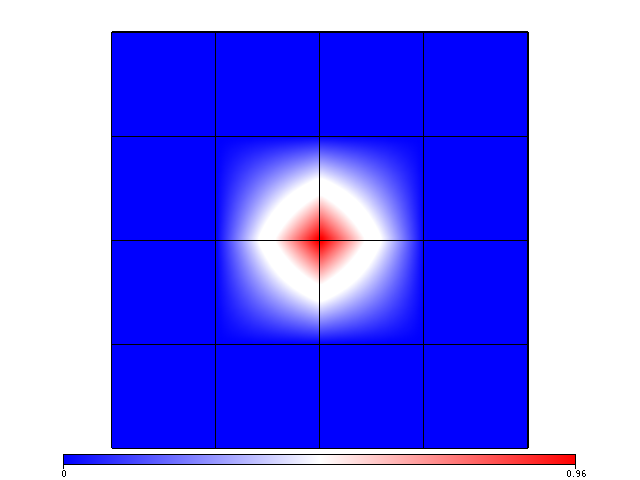

In [10]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.Mesh(temperatureMesh, colourBar = False)
fig.show()

Note that the plotting software used by underworld (``gLucifer``) interpolates between the mesh node points inside each cell. Thus the single non-zero point will have a gradient around in when plotted.

**Example 3: Smooth function**

Initialise the temperature FE variable with a function based on its spatial coordinates
\\[
T = x \left( 1 - z \right)
\\]

In [11]:
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = coord[0] * (1.0 - coord[1])

Plot result

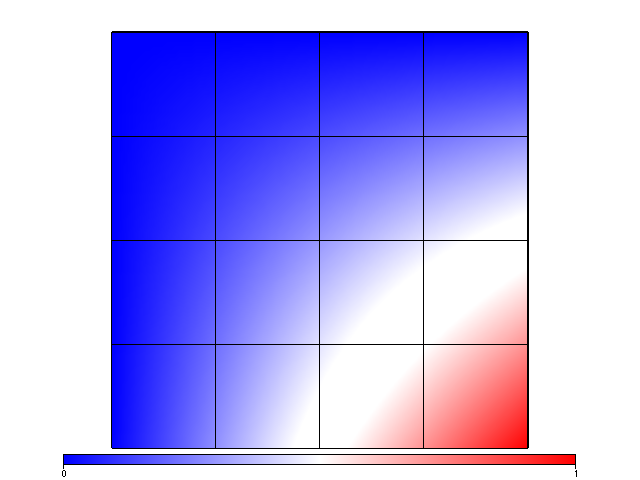

In [12]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.Mesh(temperatureMesh, colourBar = False)
fig.show()

**Example 4: Velocity field**

While a temperature field has a single value at each mesh point the velocity field will have as many values as there are dimensions in the model. In this example we will construct a velocity field for a two dimensional box.

**Create meshes and FE variables**

Note that the velocity mesh also uses the edges of each cell to define data values on, as in the temperature field case. The difference is in defining the velocity field FE variable, in that there are ``dim`` degrees of freedom rather than just one.

In [13]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 64
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight) )
temperatureMesh = elementMesh
velocityMesh    = elementMesh
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )
velocityField    = uw.fevariable.FeVariable( feMesh=velocityMesh   , nodeDofCount=dim )

**Set initial condtions for velocity and temperature**

Set the temperature to a simple gradient $T = (1 - z)$, while the velocity is set to

$$
    \mathbf{v} = \sin(x \pi) \sin(y \pi) \left( z - z_{mid}, x - x_{mid} \right)
$$

where $mid$ denotes the middle of the box.

In [14]:
coordmid = (0.5, 0.5)
for index, coord in enumerate(elementMesh.data): # using elementMesh since we are looking at T and v at once
    mag = math.sin( coord[0]*(math.pi) )*math.sin( coord[1]*(math.pi) )
    vx = -mag * (coord[1]-coordmid[1])
    vy =  mag * (coord[0]-coordmid[0])
    velocityField.data[index] = (vx, vy)
    temperatureField.data[index] = 1 - coord[1]

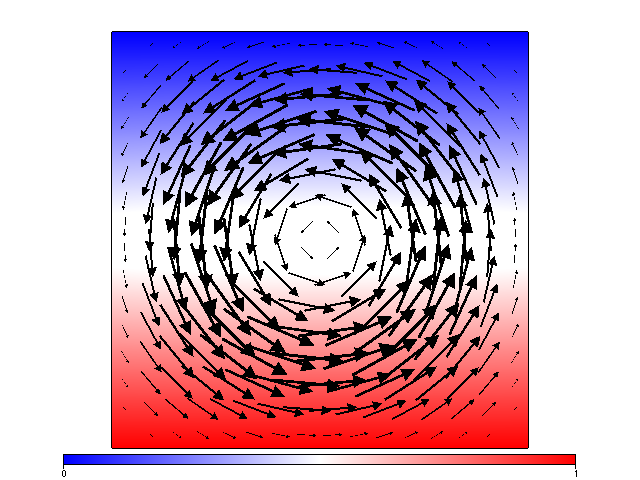

In [15]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.VectorArrows(velocityField, velocityMesh, lengthScale=1., arrowHeadSize=0.2 )
fig.show()

Loading and saving FE variables
------

In this example we will use the previous initial conditions for the temperature field, save them to file, reset them, and then recover the original data by loading from file.

**Set directory paths**

Set the directory paths for the input and output files to be stored in. These must be specified relative to the current directory (``user_guide``).

In [16]:
dirPath = 'LoadSave/'

**Quickly setup a new mesh and temperature field FE variable.**

In [17]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 64
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight) )
temperatureMesh = elementMesh
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

**Set some initial conditions for the FE variable.**

In [18]:
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = coord[0] * (1.0 - coord[1])

**Plot initial temperature field**

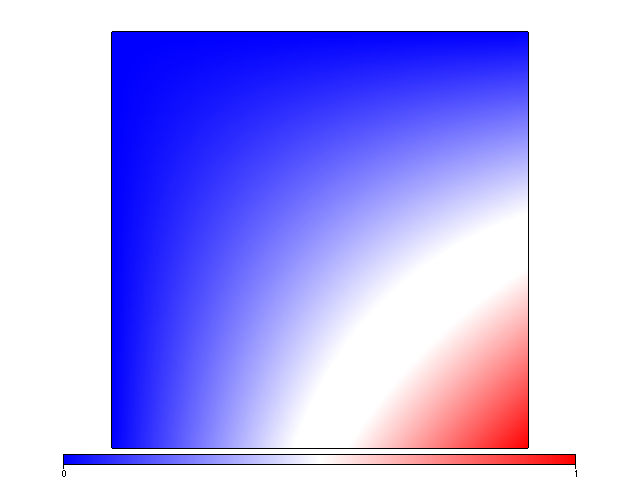

In [19]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.show()

**Save temperature field to file in local directory**

Underworld has built in functions for saving and loading FE variables to files. The file format is ``hdf5`` which is typically given the ``.h5`` file extension. For more information on ``hdf5`` see [here](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#HDF5) and regarding ``hdf5`` in python see [here](http://www.h5py.org/).

In [20]:
temperatureField.save(dirPath+'FEVariableSaveExample.h5')

**Potential error**: sometimes it will not be able to create the file, since the directory does not exist. Make sure to check your hard disk as well as the ``dirPath`` parameter set above.

**Change temperature field data and re-plot**

Having save the temperature data, now we will over write it.

In [21]:
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = float(index)

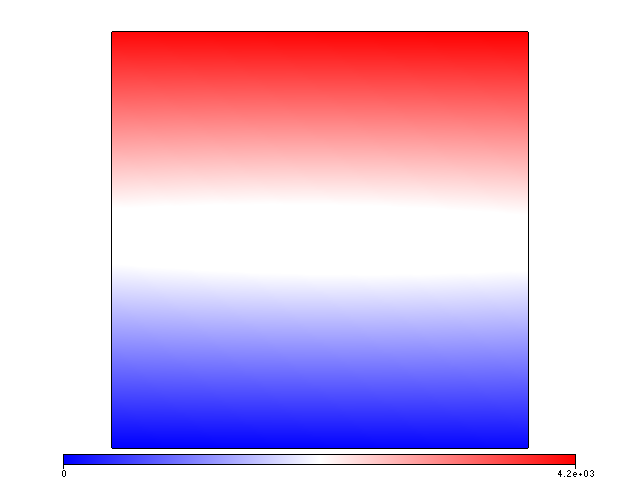

In [22]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.show()

**Reload from file and plot saved temperature field**

Now we will load the FE variable from the file we saved above. This will overwrite the data we just put in.

In [23]:
temperatureField.load(dirPath+'FEVariableSaveExample.h5')

**Potential error**: make sure that this has the same filename as previously.

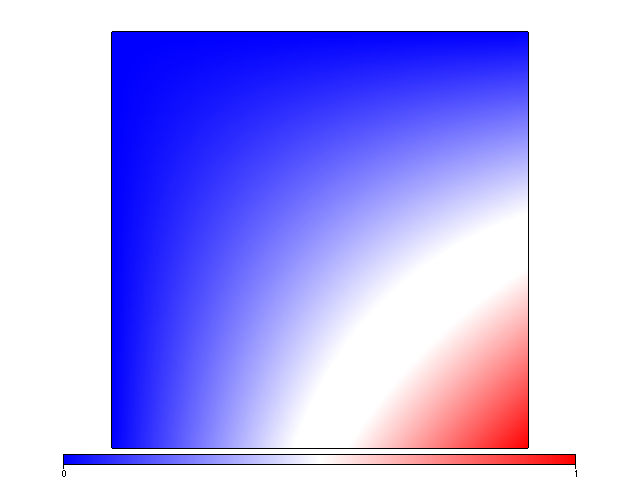

In [24]:
fig = plt.Figure()
fig.Surface(temperatureField, temperatureMesh, colours = 'blue white red')
fig.show()